https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for testidation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "kedi_kopek"

image_datasets = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), data_transforms[x]
) for x in ["train", "test"]}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ["train", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["train"].classes

# NVIDIA GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# APPLE GPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

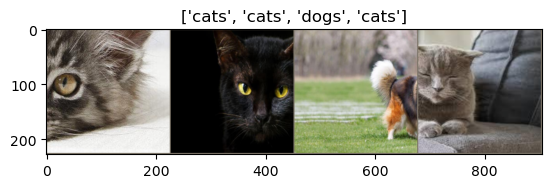

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and testidation phase
            for phase in ["train", "test"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to etestuate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "test" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best test Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5640 Acc: 0.7540
test Loss: 0.1430 Acc: 0.9429

Epoch 1/1
----------
train Loss: 0.5729 Acc: 0.7684
test Loss: 0.6659 Acc: 0.7286

Training complete in 2m 34s
Best test Acc: 0.942857


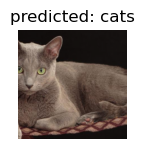

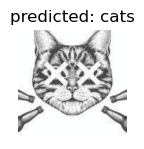

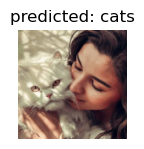

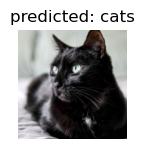

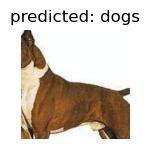

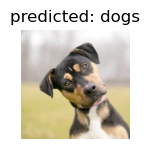

In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, 
                         criterion,
                         optimizer_conv, 
                         exp_lr_scheduler, 
                         num_epochs=2)

Epoch 0/1
----------
train Loss: 0.5034 Acc: 0.7504
test Loss: 0.0962 Acc: 0.9714

Epoch 1/1
----------
train Loss: 0.4615 Acc: 0.7899
test Loss: 0.1041 Acc: 0.9643

Training complete in 1m 55s
Best test Acc: 0.971429


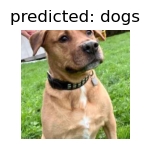

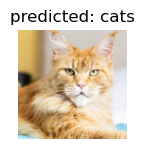

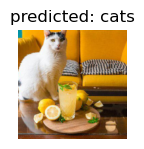

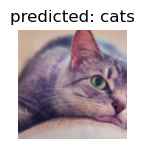

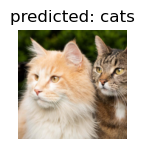

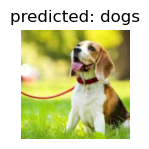

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms["test"](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

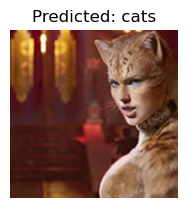

In [16]:
visualize_model_predictions(
    model_ft,
    img_path="kedi_kopek/test/cats/cat_585.jpg"
)

plt.ioff()
plt.show()

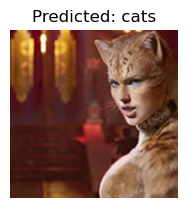

In [17]:
visualize_model_predictions(
    model_conv,
    img_path="kedi_kopek/test/cats/cat_585.jpg"
)

plt.ioff()
plt.show()